In [1]:
#import robot_motion as rm
import robot_camera
import cv2
from IPython.display import Image
from matplotlib import pyplot as plt
from cv2 import aruco
import os
import numpy as np

In [2]:
#motionsystem = rm.colonyPicker({},{},'/dev/serial0',19200)
robocam = robot_camera.robo_camera()

In [3]:
#move the needle around and take a picture
motionsystem.move_robot(px=motionsystem.robopos["neutral_position"]["0"]["X"],\
                        py = motionsystem.robopos["neutral_position"]["0"]["Y"],\
                        pz=motionsystem.robopos["neutral_position"]["0"]["Z"])
motionsystem.send_gcode_multiline(["M400"])
motionsystem.light_on()
img = robocam.capture(os.path.join(".","calibration","lighttable.png")) #blank light table photo
zup = 2
motionsystem.move_needle("backlit_plate","needle_pos",retract = False, offset_x = 10,offset_y = -10,offset_z = zup)
motionsystem.send_gcode_multiline(["M400"])
img = robocam.capture(os.path.join(".","calibration","needlepos1.png"))
motionsystem.move_needle("backlit_plate","needle_pos",retract = False, offset_x = 10,offset_y = 10,offset_z=zup)
motionsystem.send_gcode_multiline(["M400"])
img = robocam.capture(os.path.join(".","calibration","needlepos2.png"))
motionsystem.move_needle("backlit_plate","needle_pos",retract = False, offset_x = -10, offset_y = 10,offset_z=zup)
motionsystem.send_gcode_multiline(["M400"])
img = robocam.capture(os.path.join(".","calibration","needlepos3.png"))
motionsystem.move_needle("backlit_plate","needle_pos",retract = False, offset_x = -10, offset_y = -10,offset_z=zup)
motionsystem.send_gcode_multiline(["M400"])
img = robocam.capture(os.path.join(".","calibration","needlepos4.png"))
motionsystem.light_off()

NameError: name 'motionsystem' is not defined

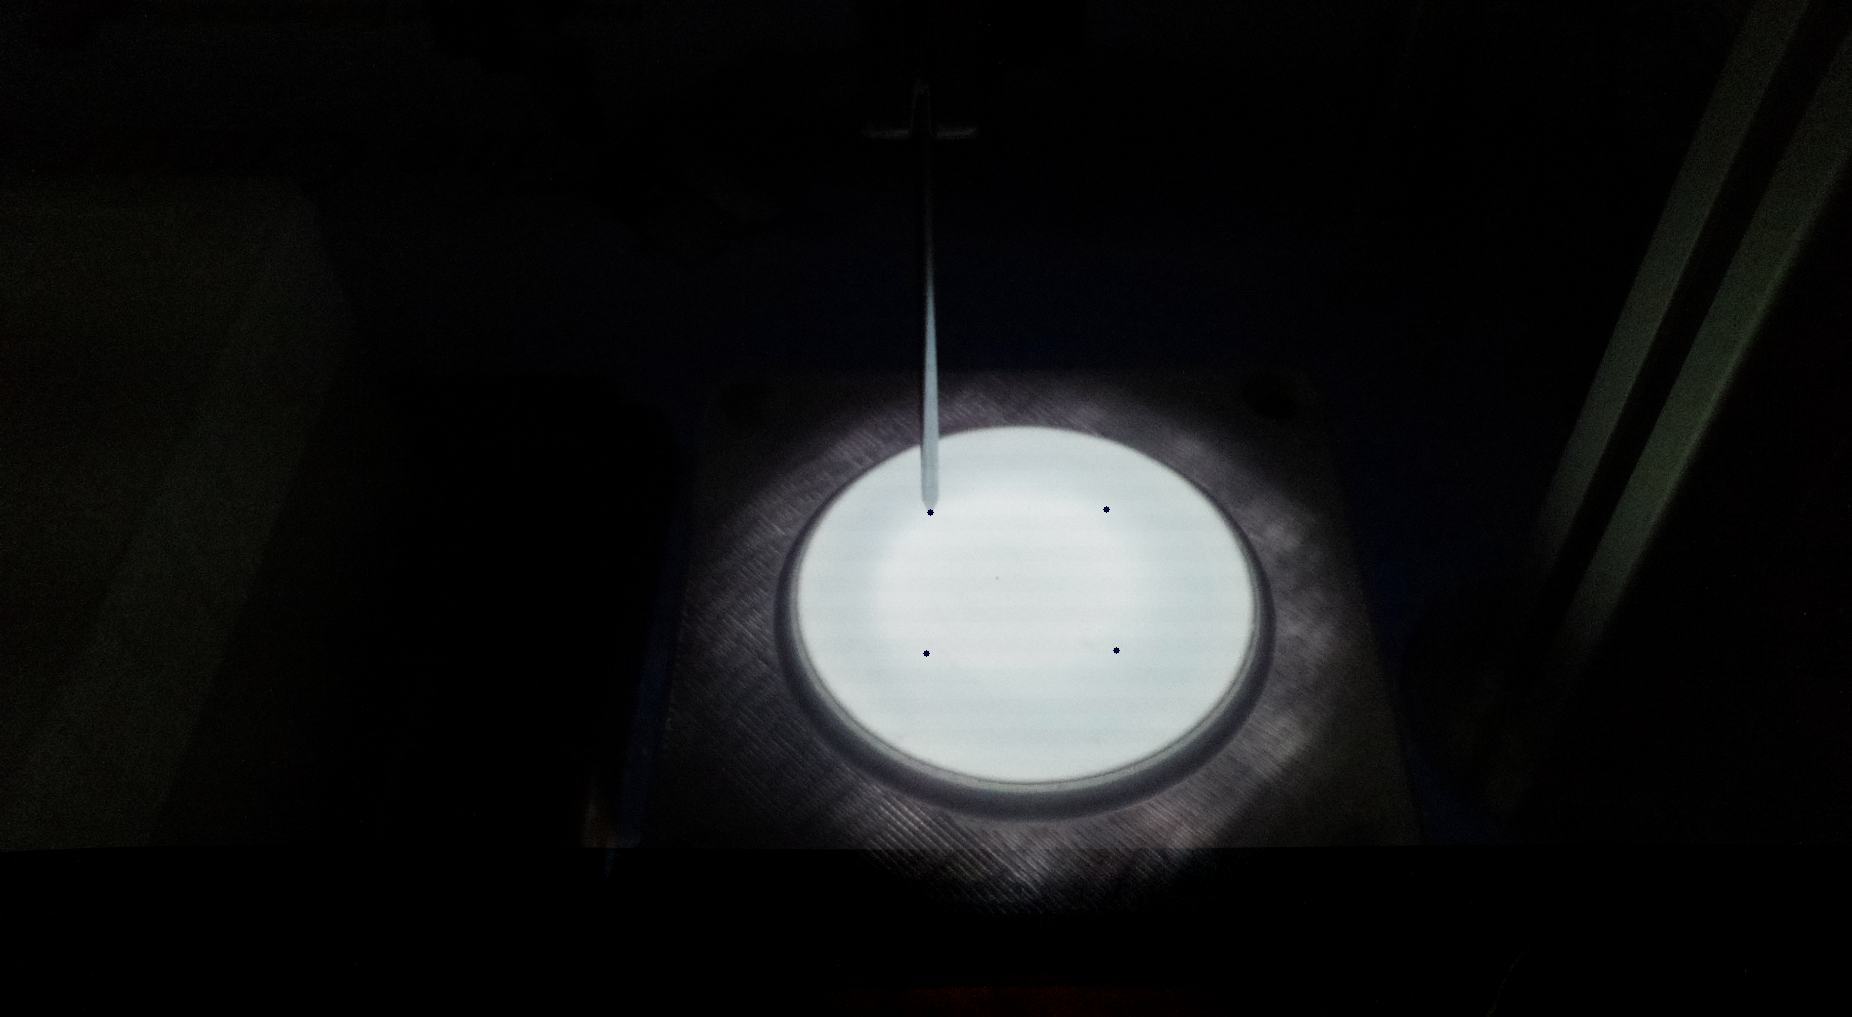

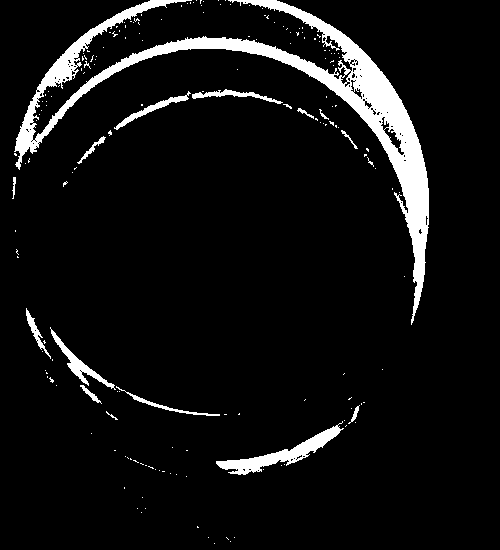

In [3]:
''
#mask the table
ltable = os.path.join(".","calibration","lighttable.png")
bgimg = cv2.imread(ltable)

thresh,bg_subtractor = robocam.mask_lit_background(bgimg)

#pictures of the colony pick needle going around in a square
npos1 = os.path.join(".","calibration","needlepos1.png")
npos2 = os.path.join(".","calibration","needlepos2.png")
npos3 = os.path.join(".","calibration","needlepos3.png")
npos4 = os.path.join(".","calibration","needlepos4.png")
needle_positions = [npos1,npos2,npos3,npos4]

needlepoints = []

for needpos in needle_positions:
    img = cv2.imread(needpos)
    npoint = robocam.detect_needle(thresh = thresh,\
            bg_subtractor=bg_subtractor,needle_image=img)
    needlepoints += [npoint]
    
''
#visualize the needle spots
for corner in needlepoints:
    x,y = corner.ravel()
    cv2.circle(img,(x,y),3,50,-1)    
#newimg = cv2.Canny(img,170,80)

cv2.imwrite('testimage.png',img)
display(Image(filename='testimage.png'))
#'''

#below are the points I got when I did the point matching with real pictures
#needlepoints = [[ 926.,  651.],
#                [1117.,  648.],
#                [1106.,  507.],
#                [ 930.,  509.]]

img = cv2.imread(os.path.join('.','pictures','B1_calibrated.png'))
trapezoid = np.array(needlepoints,np.float32)

 

#this next part warps the image so that it is rectified and in the middle of the frame
square = np.array([[0,200],[150,200],[150,50],[0,50]],np.float32)+150
transform = cv2.getPerspectiveTransform(trapezoid,square) #the transformation matrix
warp = cv2.warpPerspective(img,transform,(500,550)) #transforming the calibrated image


bg_tx = cv2.warpPerspective(bgimg,transform,(500,550)) #transforming the backdrop image
bg_tx_gray = cv2.cvtColor(bg_tx,cv2.COLOR_BGR2GRAY)
warp_grey = cv2.cvtColor(warp,cv2.COLOR_BGR2GRAY)

bg_sub2 = cv2.bgsegm.createBackgroundSubtractorMOG()
bg_sub2.apply(bg_tx_gray) #setup the background subtractor

plate_location =  bg_sub2.apply(warp_grey,learningRate=0)



warpThresh = cv2.warpPerspective(thresh,transform,(500,550))

#identify the yellow circle
im_hsv = cv2.cvtColor(warp,cv2.COLOR_BGR2HSV)
lower_red = np.array([22,10,130])
upper_red = np.array([28,255,255])

yellowmask = cv2.inRange(im_hsv,lower_red,upper_red)

kernel = np.ones((5,5), np.uint8) 
yellowmask = cv2.erode(yellowmask,kernel,iterations=5)
yellowmask = cv2.dilate(yellowmask,kernel,iterations=5)

#yellowmask = cv2.cvtColor(yellowmask,cv2.COLOR_GRAY2RGB)
contours1, _ = cv2.findContours(yellowmask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
contours2, _= cv2.findContours(warpThresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

#below is for displaying the masks
#yellowmask = cv2.merge([yellowmask,yellowmask*0,yellowmask*0])
#newthresh = cv2.merge([warpThresh*0,warpThresh,warpThresh])
#yellowalpha = .2

#cv2.addWeighted(yellowmask,yellowalpha,warp,1-yellowalpha,0,warp)
#cv2.addWeighted(newthresh,yellowalpha,warp,1-yellowalpha,0,warp)

#print(contours1)

for j,contour in enumerate(contours2):
     hull = cv2.convexHull(contour)
     cv2.drawContours(warp, [hull], -1, (0, 255, 0), 3) 

for j,contour in enumerate(contours1):
     hull = cv2.convexHull(contour)
     cv2.drawContours(warp, [hull], -1, (125, 125, 0), 3) 

#yellowedge = cv2.Canny(yellowmask,400,500)
#mask_visualized = warp+yellowedge

#hue, sat, val = im_hsv[:,:,0], im_hsv[:,:,1], im_hsv[:,:,2]

#plt.figure(figsize=(10,8))
#plt.subplot(311)                             #plot in the first cell
#plt.subplots_adjust(hspace=.5)
#plt.title("Hue")
#plt.hist(np.ndarray.flatten(hue), bins=180)
#plt.subplot(312)                             #plot in the second cell
#plt.title("Saturation")
#plt.hist(np.ndarray.flatten(sat), bins=128)
#plt.subplot(313)                             #plot in the third cell
#plt.title("Luminosity Value")
#plt.hist(np.ndarray.flatten(val), bins=128)
#plt.show()

cv2.imwrite("circularized.png",plate_location)
Image("circularized.png")

In [5]:
motionsystem.light_off()

NameError: name 'motionsystem' is not defined

[array([[[1212.,  716.],
        [ 889.,  719.],
        [ 893.,  483.],
        [1177.,  479.]]], dtype=float32)]


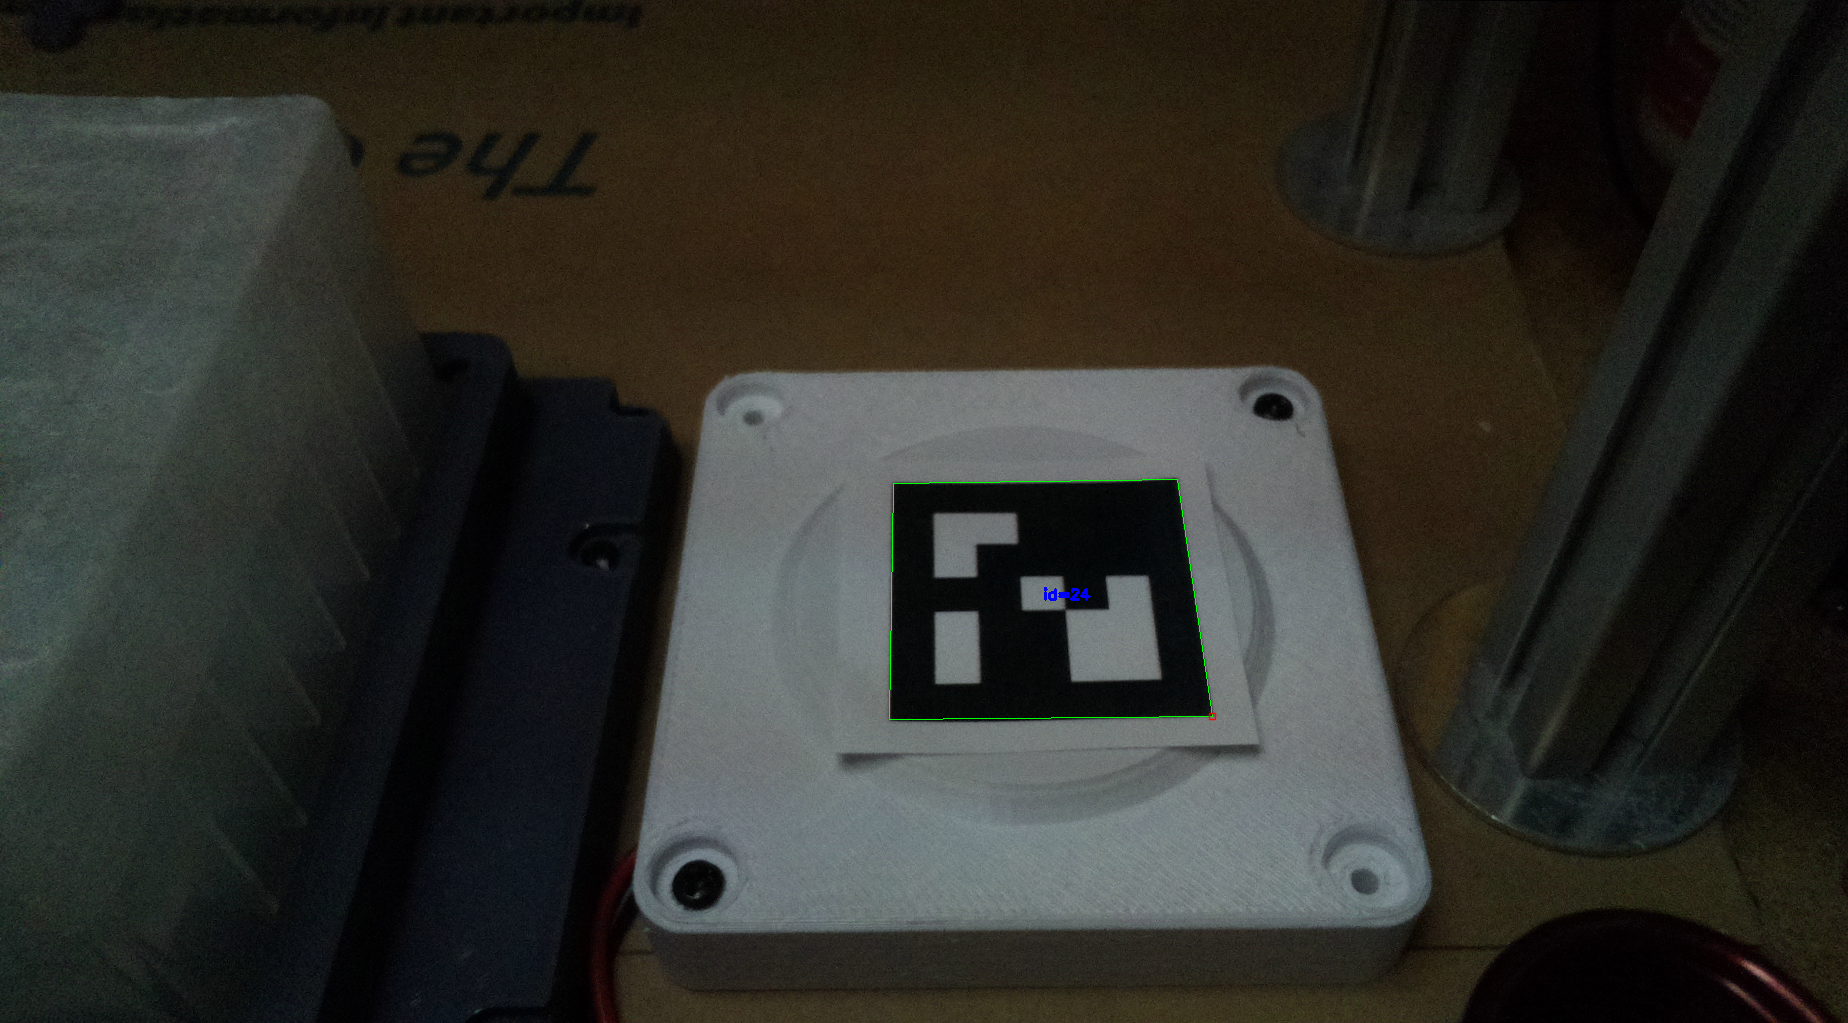

In [6]:
dictionary = aruco.Dictionary_get(aruco.DICT_5X5_250)
parameters =  aruco.DetectorParameters_create()

img = cv2.imread(os.path.join(".","calibration","aruco1.png"))
corners, ids, rejectedCandidates = aruco.detectMarkers(img, dictionary, parameters=parameters)
frame_markers = aruco.drawDetectedMarkers(img.copy(), corners, ids)
#this part is writing and reading an image to display it in the notebook
cv2.imwrite('testimage.png',frame_markers)
print(corners)
Image(filename='testimage.png') 


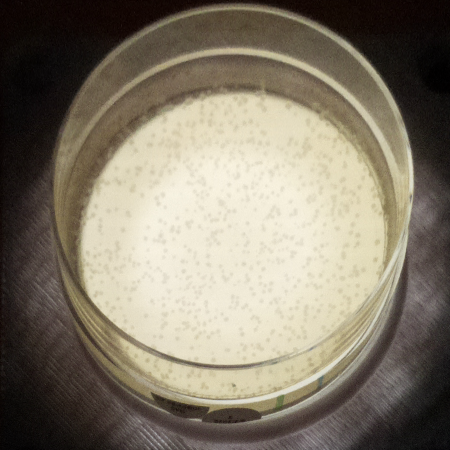

In [7]:
img = cv2.imread(os.path.join('.','pictures','A2.png'))
aruco=np.array([[1205.,  711.],
        [ 894.,  713.],
        [ 900.,  488.],
        [1173.,  486.]], np.float32)

square = np.array([[200,200], [0,200],[0,0],[200,0]],np.float32)+130
transform = cv2.getPerspectiveTransform(aruco,square)
warp = cv2.warpPerspective(img,transform,(450,450))

cv2.imwrite("circularized.png",warp)
Image("circularized.png")

In [8]:
import numpy as np
A1file ='circularized.png' 
img = cv2.imread(A1file)
#newimg = cv2.Canny(img,200,100)
#kernel = np.ones((2,2),np.uint8)
#newimg = cv2.dilate(newimg,kernel,iterations = 1)

cv2.imwrite('testimage.png',newimg)
#cimg = newimg
cimg = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
#circles = cv2.HoughCircles(cimg,cv2.HOUGH_GRADIENT,1,15,
#                            param1=150,param2=80,minRadius=170,maxRadius=220)
circles = cv2.HoughCircles(cimg,cv2.HOUGH_GRADIENT,1,20,
                            param1=215,param2=57,minRadius=160,maxRadius=185)
print(circles)
circles = np.uint16(np.around(circles))

for i in circles[0,:]:
    # draw the outer circle
    cv2.circle(img,(i[0],i[1]),i[2],(0,255,0),2)
    # draw the center of the circle
    cv2.circle(img,(i[0],i[1]),2,(0,0,255),3)
cv2.imwrite('testimage.png',img)

Image(filename='testimage.png') 

NameError: name 'newimg' is not defined